# Importation

In [1]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt,freqz
from sklearn import *
from sklearn.metrics import f1_score
import lightgbm as lgb
import xgboost as xgb
import gc
import matplotlib.pyplot as plt 

import scipy as sc
from tqdm.notebook import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import time
import datetime
from sklearn.model_selection import KFold


In [2]:

def dft_shift(X):   
    N = len(X)    
    if (N % 2 == 0):        # even-length: return N+1 values  
        return np.arange(-int(N/2), int(N/2) + 1), np.concatenate((X[int(N/2):], X[:int(N/2)+1]))    
    else:        # odd-length: return N values       
        return np.arange(-int((N-1)/2), int((N-1)/2) + 1), np.concatenate((X[int((N+1)/2):], X[:int ((N+1)/2)])) 

def dft_map(X, Fs, shift=True):    
    resolution = float(Fs) / len(X)    
    if shift:        
        n, Y = dft_shift(X)   
    else:        
        Y = X       
        n = np.arange(0, len(Y))
    f = n * resolution    
    return f, Y

# Load the Data 

In [3]:
train = pd.read_csv('../input/data-without-drift/train_clean.csv')
test = pd.read_csv('../input/data-without-drift/test_clean.csv')

In [4]:
def batch_group(x) : 
    return x//500000

In [5]:
train = train.reset_index()
train['batch'] = train['index'].apply(batch_group)

In [6]:
test = test.reset_index()
test['batch'] = test['index'].apply(batch_group)

# Remove the noise 

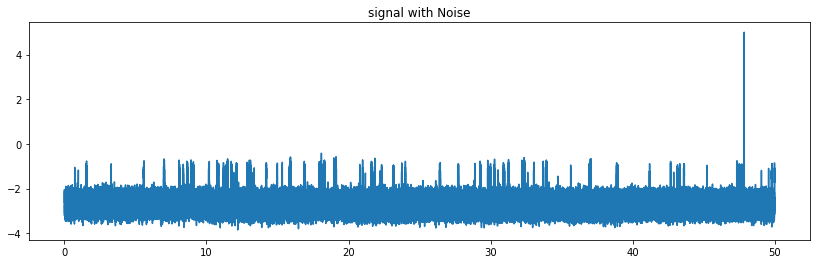

In [7]:
Fs = 10000
batch = train[train['batch']==0]
signal = batch['signal'].values
plt.rcParams["figure.figsize"] = (14,4)
N=int(len(signal)) 
T=(N-1)/Fs 
t=np.linspace(0,T,N) 
plt.plot(t,signal) 
plt.title('signal with Noise')
plt.show()

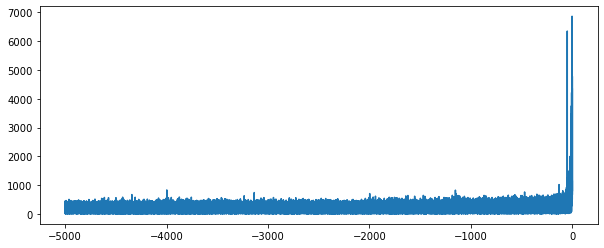

In [8]:
signal = signal - signal.mean()
plt.rcParams["figure.figsize"] = (10,4) 
X=np.fft.fft(signal)  
y,f=dft_map(X, Fs)
plt.plot(y[:N//2 - 10],abs(f[:N//2 - 10]))

In [9]:
for x in range(100) : 
    maxi = np.argmax(abs(X[1000:N-1000]))
    maxi = maxi+1000
    for i in range(maxi-50,maxi+50) :       
            X[i] = 0 

In [10]:
np.argwhere(abs(X)==0).shape

(8374, 1)

In [11]:
maxi = np.argwhere(abs(y)==50).reshape(1,-1)[0]
for m in maxi :  
        for i in range(m-1000,m+1000) :       
            X[i] = 0

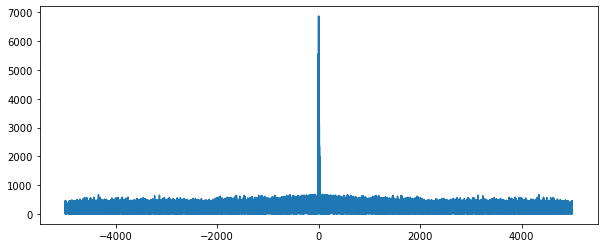

In [12]:
plt.rcParams["figure.figsize"] = (10,4) 
y,f=dft_map(X, Fs)
plt.plot(y,abs(f))

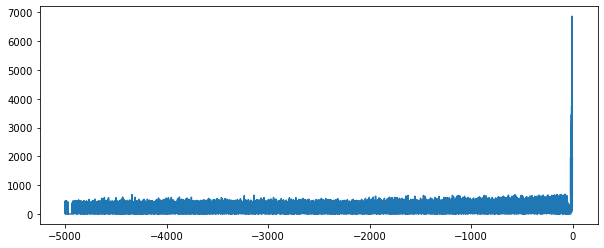

In [13]:
signal = signal - signal.mean()
plt.rcParams["figure.figsize"] = (10,4) 
y,f=dft_map(X, Fs)
plt.plot(y[:N//2 - 100],abs(f[:N//2 - 100]))

In [14]:
def def_50hz_denosing(signal) : 
    X=np.fft.fft(signal)  
    
    for x in range(100) : 
        ma = np.argmax(abs(X[500:N-500]))
        ma = ma+500
        for i in range(ma-250,ma+250) :       
                X[i] = 0 
    
    for m in maxi :  
        for i in range(m-500,m+500) :       
            X[i] = 0.05 * X[i]  
    s = np.fft.ifft(X)
    return s 

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


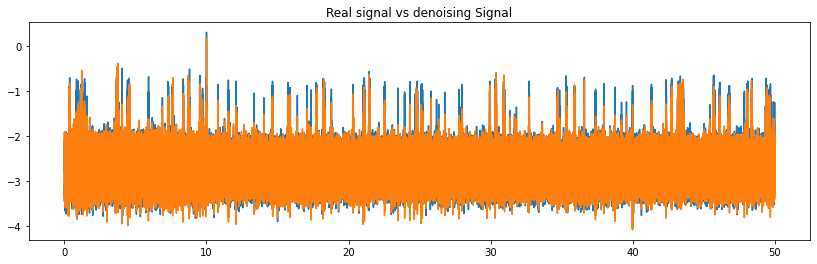

In [15]:
Fs = 10000
batch = train[train['batch']==1]
signal = batch['signal'].values
plt.rcParams["figure.figsize"] = (14,4)
N=int(len(signal)) 
T=(N-1)/Fs 
t=np.linspace(0,T,N) 
plt.plot(t,signal) 
signal_without_noise = def_50hz_denosing(signal)
plt.plot(t,signal_without_noise)
plt.title('Real signal vs denoising Signal')
plt.show()

In [16]:
for batch in tqdm(train['batch'].unique()) : 
    index = train[train['batch']==batch].index
    signal = train[train['batch']==batch]['signal'].values
    signal_without_noise = def_50hz_denosing(signal)
    train.loc[index,'clean_signal'] = signal_without_noise.real

In [17]:
for batch in tqdm(test['batch'].unique()) : 
    index = test[test['batch']==batch].index
    signal = test[test['batch']==batch]['signal'].values
    signal_without_noise = def_50hz_denosing(signal)
    test.loc[index,'clean_signal'] = signal_without_noise.real

# Data preprocessing

In [18]:
# config
SEQ_LEN = 4000
lag_len = 15 

In [19]:
# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['clean_signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['clean_signal'].shift(-1 * window).fillna(0)
    return df

In [20]:
def run_feat_engineering(df):
    # create leads and lags (1, 2, 3,4 making them 8 features)
    win = [i for i in range(1,lag_len)]
    df = lag_with_pct_change(df, win)
    return df

In [21]:
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index','group', 'batch', 'open_channels', 'time','bacth_std','bacth_mean','bacth_var']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

In [22]:
train, test, features = feature_selection(train,test)

In [23]:

def group_batch(x) : 
    return x//SEQ_LEN
train['group'] = train['index'].apply(group_batch)

test['group'] = train['index'].apply(group_batch)

In [24]:
train = run_feat_engineering(train)
test = run_feat_engineering(test)

In [25]:
tqdm.pandas()
def fft_abs(x) : 
  x=np.fft.fft(x)  
  return  abs(x)[:lag_len+1] 
signal = ['signal_shift_neg_' + str(window) for window in range(1,lag_len)]+ ['clean_signal']+ ['signal_shift_pos_' + str(window) for window in range(1,lag_len)] 
train['fft_abs'] = train[signal].progress_apply(fft_abs,axis = 1 ).values.reshape(-1,1)
test['fft_abs'] = test[signal].progress_apply(fft_abs,axis = 1 ).values.reshape(-1,1)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [26]:
gc.collect()

23

In [27]:
signal = ['signal_shift_neg_' + str(window) for window in range(1,lag_len)]+ ['signal_shift_pos_' + str(window) for window in range(1,lag_len)] 

train.drop(signal,1,inplace=True)
test.drop(signal,1,inplace=True)


In [28]:
train.drop(['index','group','batch'],1,inplace=True)

In [29]:
def fft_index(x) : 
  return x[index] 
for i in tqdm(range(lag_len+1) ): 
  index = i 
  train[f'fft_{i}'] = train['fft_abs'].apply(fft_index)
  test[f'fft_{i}'] = test['fft_abs'].apply(fft_index)


In [30]:
train.drop('fft_abs',axis=1,inplace =True)
test.drop('fft_abs',axis=1,inplace =True)



In [31]:
test.drop(['index','batch','group'],1,inplace = True)

In [32]:
train.to_csv('train.csv',index = False) 
test.to_csv('test.csv',index = False) 